In [96]:
# load the "autoreload" extension so that code can change
%load_ext autoreload
# always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
from warnings import filterwarnings
filterwarnings('ignore')

# Normalization of the Power Signal

Author: Clemens Jochum

Normalize the power signal in order to obtain the performance index (PI). The resulting performance index is aggregated daily in order to obtain a daily time-series. The normalization code presented here mirrors the normalization method by Daniel Fregosi that he uses for the input to `rdtools`.

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.data.import_data import import_df_from_zip_pkl, import_df_info_from_zip
from src.features.performance_index import normalize_power_signal
from src.data.make_dataset import downsample_dataframe

In [4]:


#plt.rcParams["figure.figsize"] = [10, 5]
#plt.rcParams['figure.dpi'] = 250
#'font.size': 10, 'savefig.dpi': 72, 'figure.subplot.bottom': 0.125

### Obtain the reference clearsky irradiance

Obtain the reference clearsky irradiance (POA) for `synthetic_weather` and `synthetic_soil_weather` datasets from external data.

In [99]:
# load reference poa
path_to_poa_reference = '../data/raw/clearsky_poa_reference/clear_sky_CO.pkl'
poa_reference_02 = pd.read_pickle(path_to_poa_reference, compression='gzip')

# pad missing values w/ zeros
t_begin = pd.Timestamp('2015-01-01 00:00:00').tz_localize('Etc/GMT+7')
t_final = pd.Timestamp('2019-12-31 23:59:00').tz_localize('Etc/GMT+7')
datetime_01 = pd.date_range(t_begin, poa_reference_02.index[0], freq='min')[:-1]
datetime_03 = pd.date_range(poa_reference_02.index[-1], t_final, freq='min')[1:]
poa_reference_01 = pd.Series(data=0., index=datetime_01, name='POAcs')
poa_reference_03 = pd.Series(data=0., index=datetime_03, name='POAcs')
poa_reference = pd.concat((poa_reference_01, poa_reference_02, poa_reference_03))

### Normalize a Dataset

Normalize the dataset of `data_key`. Example given here is for `data_key = soil_weather`, i.e., the `synthetic_soil_weather` dataset.

In [101]:
# set parameters
data_key = 'soil_weather'
n_samples = 50
path_to_dataset = '../data/raw/synthetic_soil_weather.zip'

In [105]:
# test the data import
df_test = import_df_from_zip_pkl(path_to_dataset, index=n_samples-1)
df_info = import_df_info_from_zip(path_to_dataset)
print(df_info.tail(-1))

                         Plant  Degradation_rate_linear Location
0   synthetic_soil_weather_001                -0.015679       CO
1   synthetic_soil_weather_002                -0.007176       CO
2   synthetic_soil_weather_003                -0.008677       CO
3   synthetic_soil_weather_004                -0.014495       CO
4   synthetic_soil_weather_005                -0.012073       CO
5   synthetic_soil_weather_006                -0.011151       CO
6   synthetic_soil_weather_007                -0.014111       CO
7   synthetic_soil_weather_008                -0.009140       CO
8   synthetic_soil_weather_009                -0.011115       CO
9   synthetic_soil_weather_010                -0.009889       CO
10  synthetic_soil_weather_011                -0.010433       CO
11  synthetic_soil_weather_012                -0.010876       CO
12  synthetic_soil_weather_013                -0.002871       CO
13  synthetic_soil_weather_014                -0.014503       CO
14  synthetic_soil_weathe

In [124]:


poa_reference_02 = pd.read_pickle('../data/raw/clear_sky_CO.pkl', compression='gzip')

t_begin = pd.Timestamp('2015-01-01 00:00:00').tz_localize('Etc/GMT+7')
t_final = pd.Timestamp('2019-12-31 23:59:00').tz_localize('Etc/GMT+7')
datetime_01 = pd.date_range(t_begin, poa_reference_02.index[0], freq='min')[:-1]
datetime_03 = pd.date_range(poa_reference_02.index[-1], t_final, freq='min')[1:]

poa_reference_01 = pd.Series(data=0., index=datetime_01, name='POAcs')
poa_reference_03 = pd.Series(data=0., index=datetime_03, name='POAcs')

poa_reference_co = pd.concat((poa_reference_01, poa_reference_02, poa_reference_03))

#print(pd.Timedelta(poa_reference_02.index[0] - t_begin).seconds / 60)
#print(pd.Timedelta(t_final - poa_reference_02.index[-1]).seconds / 60)
#print(pd.date_range(t_begin, poa_reference_02.index[0], freq='min')[:-1].size)
#print(pd.date_range(poa_reference_02.index[-1], t_final, freq='min')[1:].size)

#poa_reference[:7*1440].plot()
#print(df.POA.size - poa_reference.size)


In [125]:
for index in range(1):
    df = import_df_from_zip_pkl(path_to_dataset, index)
    
    outlier_threshold = 0.0
    
    if data_key in ['basic', 'soil']:
        clearsky = False
    else:
        clearsky = True
    
    if data_key in ['basic', 'soil']:
        poa_reference = None
    elif data_key in ['soil_weather', 'weather']:
        poa_reference = poa_reference_co
    
    p_norm_daily_clipping_basic = normalize_power_signal(df, poa_reference, clearsky=clearsky, clipping='basic', verbose=True, outlier_threshold = outlier_threshold)
    #p_norm_daily_clipping_flexible = normalize_power_signal(df, poa_reference, clearsky=clearsky, nighttime=True, clipping='flexible', verbose=True, outlier_threshold = outlier_threshold)
    #p_norm_daily_clipping_universal = normalize_power_signal(df, poa_reference, clearsky=clearsky, nighttime=True, clipping='universal', verbose=True, outlier_threshold = outlier_threshold)
       
    #df_pkl = downsample_dataframe(df)
    #df_pkl['PI_clipping_basic'] = p_norm_daily_clipping_basic
    #df_pkl['PI_clipping_flexible'] = p_norm_daily_clipping_flexible
    #df_pkl['PI_clipping_universal'] = p_norm_daily_clipping_universal
    #df_pkl.to_pickle('../data/raw/synthetic_{:s}_pi_daily_{:s}.pkl'.format(data_key, str(index+1).zfill(3)), compression = 'gzip', protocol = 3)

0.10 % of data remaining after clearsky-detection, nighttime-removal, and clipping-removal


<AxesSubplot:xlabel='datetime'>

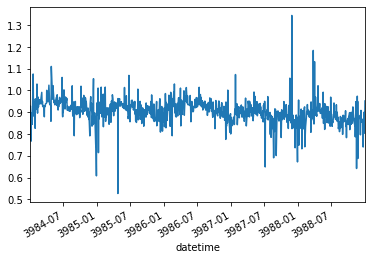

In [126]:
p_norm_daily_clipping_basic.plot()
#df_pkl[df_pkl.PI_clipping_flexible.notna()].PI_clipping_flexible.plot()
#df_pkl[df_pkl.PI_clipping_universal.notna()].PI_clipping_universal.plot()
#print(p_norm_daily_clipping_basic[:20])
#night_mask = df.Power != -1.
#print(df.POA[df.Power != -1.])

In [90]:
def detect_outliers(pi_signal, threshold_min = 0.70, threshold_max = 1.00, verbose=False):
    
    signal_size = df_pi.PI_clipping_basic.size
    signal_notna_size = df_pi.PI_clipping_basic.notna().sum()
    n_nans_before = df_pi.PI_clipping_basic.isna().sum()
    
    if verbose is True:
        print(f'\nPI signal contains {n_nans_before / signal_size * 100.:.2f} % NaNs\n')
    
    mask_outliers_above = df_pi.PI_clipping_basic > threshold_max
    mask_outliers_below = df_pi.PI_clipping_basic < threshold_min
    mask_outliers = np.logical_or(mask_outliers_above, mask_outliers_below)
    n_outliers = mask_outliers.sum()
    ratio_outliers = n_outliers / signal_notna_size
    percent_outliers = ratio_outliers * 100.
    
    if verbose is True:
        print(f'detected {n_outliers:d} outliers (corresponging to {percent_outliers:.2f} % of non-NaN PI signal)\n')
    
    return mask_outliers, n_outliers, ratio_outliers
    
    
    
    

In [95]:
path = '../data/raw/new/synthetic_soil_weather_pi_daily_uniform.zip'

perc_max = 0
num_max = 0
for i in range(50):
    df_pi = import_df_from_zip_pkl(path, index=i, minofday=False)
    mask, num, perc = detect_outliers(df_pi.PI_clipping_basic)
    if perc > perc_max: perc_max = perc
    if num > num_max: num_max = num

print(perc, num)

0.025889967637540454 32


In [59]:
path = '../data/raw/new/synthetic_soil_weather_pi_daily_uniform.zip'
df_pi = import_df_from_zip_pkl(path, index=0, minofday=False)

detect_outliers(df_pi.PI_clipping_basic, 0.6, 1.0)


performance index contains 29.74 % NaNs

detected 51 outliers

51


In [35]:





# test
#path = '../synthetic_soil_weather_pi_daily_001.pkl'
path = '../data/raw/new/synthetic_soil_weather_pi_daily_uniform.zip'
#df_pi = pd.read_pickle(path, compression='gzip')
global_min = 1.0
global_max = 1.0
for i in range(150):
    df_pi = import_df_from_zip_pkl(path, index=i,minofday=False)
    local_min = df_pi.PI_clipping_basic.min()
    local_max = df_pi.PI_clipping_basic.max()
    if local_max > global_max: global_max = local_max
    #df_pi.PI_clipping_basic.plot()
    #plt.show()
    #df_pi = df_pi[df_pi.PI_clipping_basic.notna()]
    print((df_pi.PI_clipping_basic > 1.0).sum() / df_pi.size)
    
    
0
#print(df_pi.PI_clipping_basic.isna().sum())
#print(local_min, local_max)
#df_pi[df_pi.PI_clipping_basic.notna()].PI_clipping_basic.plot()
#df_pi[df_pi.PI_clipping_flexible.notna()].PI_clipping_flexible.plot()
#df_pi[df_pi.PI_clipping_universal.notna()].PI_clipping_universal.plot()


0.0015334063526834612
0.0017524644030668128
0.0023001095290251915
0.003943044906900329
0.0025191675794085434
0.0035049288061336256
0.0013143483023001095
0.0016429353778751369
0.0009857612267250822
0.0009857612267250822
0.0012048192771084338
0.0014238773274917853
0.00208105147864184
0.0014238773274917853
0.0016429353778751369
0.0018619934282584885
0.0014238773274917853
0.0019715224534501644
0.0038335158817086527
0.001095290251916758
0.0008762322015334064
0.0009857612267250822
0.0009857612267250822
0.00208105147864184
0.0019715224534501644
0.0040525739320920046
0.004271631982475356
0.0006571741511500548
0.0007667031763417306
0.0024096385542168677
0.0009857612267250822
0.0012048192771084338
0.00208105147864184
0.0008762322015334064
0.0017524644030668128
0.0032858707557502738
0.0017524644030668128
0.0016429353778751369
0.002628696604600219
0.003723986856516977
0.0013143483023001095
0.0025191675794085434
0.001095290251916758
0.0019715224534501644
0.0007667031763417306
0.002190580503833516
0

0

In [40]:
df_pi = df_pi[df_pi.PI_clipping_basic.isna()]
df_pi.PI_clipping_basic > 1.

datetime
2015-01-02 00:00:00-07:00    False
2015-01-09 00:00:00-07:00    False
2015-01-16 00:00:00-07:00    False
2015-01-25 00:00:00-07:00    False
2015-01-30 00:00:00-07:00    False
                             ...  
2019-12-18 00:00:00-07:00    False
2019-12-21 00:00:00-07:00    False
2019-12-26 00:00:00-07:00    False
2019-12-29 00:00:00-07:00    False
2019-12-31 00:00:00-07:00    False
Name: PI_clipping_basic, Length: 584, dtype: bool

In [ ]:
help(import_df_from_zip_pkl)